# k8s 이벤트 추출 

* k8s 이벤트는 1시간까지만 조회가 가능.
* 이벤트의 시간이 *분전으로 상대적으로 표시되는 것을 custom-columns 를 통해 시간으로 표시하도록 변경
* 이벤트를 10분마다 저장하도록 함. 

## 이벤트 저장

```bash
❯ cat save-events.sh   
#!/usr/bin/env bash

filename=k8s_events/k8s-$(date '+%Y-%m-%d_%H%M%S').log.bz2
kubectl get events \
    -A \
    -o custom-columns=Reason:.reason,Date:.firstTimestamp,Namespace:.metadata.namespace,Name:.metadata.name,Message:.message \
    | grep -v "sync" \
    | bzip2 - > $filename

sync

bzcat $filename
```

## 10분 마다 이벤트 저장

```bash
watch -d -n 600 "bash save-events.sh"
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display
from dateutil.parser import parse as parse_date
from crawler.utils.k8s_events import K8sEvents

In [3]:
%matplotlib inline

plt.style.use('ggplot')

In [61]:
def custom_display(df: pd.DataFrame):
    pd.set_option('display.float_format', '{:.1f}'.format)    
    display(df.style.set_properties(**{'text-align': 'right'}))

In [4]:
events = K8sEvents()

In [5]:
data, _ = events.load_events()
df_full = events.to_dataframe(data=data)

load_events:events/k8s-2021-03-09_072434.log.bz2: 100%|██████████| 2/2 [00:00<00:00,  7.99it/s]


Unknown string format: Date {'Reason': 'Reason', 'Date': 'Date', 'Namespace': 'Namespace', 'Name': 'Name', 'Message': 'Message'}


,Date
Reason,
BackOff,1214
BackoffLimitExceeded,22
CREATE,41
Completed,9556
Created,114048
Failed,43513
FailedCreatePodSandBox,42633
FailedKillPod,102
FailedMount,139


<AxesSubplot:ylabel='Reason'>

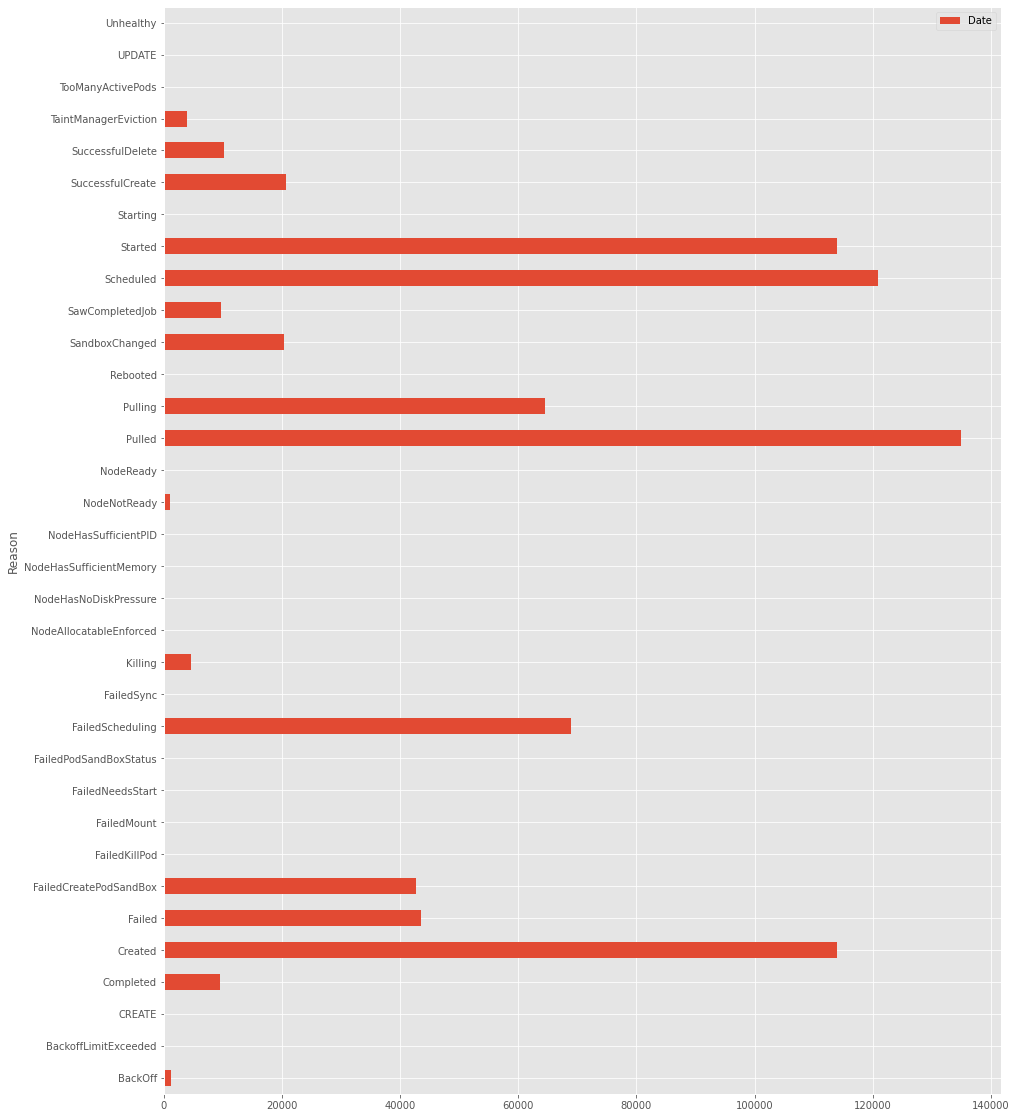

In [63]:
df_count = df_full['Reason,Date'.split(',')].groupby(by=['Reason']).count()

custom_display(df_count)

df_count.plot(kind='barh', figsize=(15,20))

In [12]:
df = df_full['Namespace,Date,Reason'.split(',')]

df = df[ df['Namespace'] != 'default' ]
df = df[ df['Reason'] == 'Created' ]['Namespace,Date'.split(',')]

df

,Namespace,Date
1,airflow,2021-03-09 01:02:23+09:00
3,airflow,2021-03-09 03:22:01+09:00
5,airflow,2021-03-09 00:09:34+09:00
15,community,2021-03-08 20:32:18+09:00
19,dev,2021-03-08 18:50:35+09:00
...,...,...
785129,airflow,2021-03-08 12:53:19+09:00
785131,dev,2021-03-09 05:22:01+09:00
785143,airflow,2021-03-08 18:11:18+09:00
785145,airflow,2021-03-08 23:26:38+09:00


# 전체 네임스페이스 시간 단위 pod 실행 개수 

<AxesSubplot:ylabel='Namespace'>

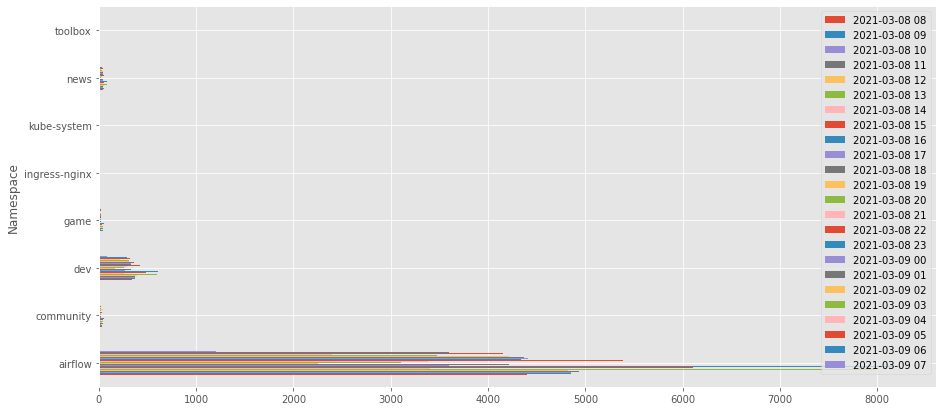

In [64]:
df_h = df

df_count = df_h.groupby(
    by=['Namespace',
        sorted(df_h['Date'].dt.strftime('%Y-%m-%d %H'))]).count()

custom_display(df_count)

df_count['Date'].unstack().plot(kind='barh', figsize=(15, 7))

# https://github.com/scentellegher/code_snippets/blob/master/pandas_groupby_unstack/Plot_groupby_multiple_columns_unstack.ipynb

# airflow: 1분 단위 pod 실행 개수 

In [65]:
freq = '1min'
df_airflow = df[ df['Namespace'] == 'airflow'].set_index('Date')

df_count = df_airflow.groupby(by=pd.Grouper(freq=freq)).count()

custom_display(df_count.describe())
custom_display(df_count)

# df_count.plot(kind='barh', figsize=(15,60))

,Namespace
count,1401.000000
mean,73.955032
std,48.303373
min,0.000000
25%,41.000000
50%,65.000000
75%,97.000000
max,414.000000


,Namespace
Date,
2021-03-08 08:04:00+09:00,1
2021-03-08 08:05:00+09:00,101
2021-03-08 08:06:00+09:00,65
2021-03-08 08:07:00+09:00,45
2021-03-08 08:08:00+09:00,96
2021-03-08 08:09:00+09:00,94
2021-03-08 08:10:00+09:00,94
2021-03-08 08:11:00+09:00,59
2021-03-08 08:12:00+09:00,59


# airflow: 5분 단위 pod 실행 개수 

In [66]:
freq = '5min'
df_airflow = df[ df['Namespace'] == 'airflow'].set_index('Date')

df_count = df_airflow.groupby(by=pd.Grouper(freq=freq)).count()

custom_display(df_count.describe())
custom_display(df_count)

# df_count.plot(kind='barh', figsize=(15,30))

,Namespace
count,281.000000
mean,368.722420
std,200.697857
min,1.000000
25%,224.000000
50%,338.000000
75%,469.000000
max,1335.000000


,Namespace
Date,
2021-03-08 08:00:00+09:00,1
2021-03-08 08:05:00+09:00,401
2021-03-08 08:10:00+09:00,413
2021-03-08 08:15:00+09:00,439
2021-03-08 08:20:00+09:00,541
2021-03-08 08:25:00+09:00,342
2021-03-08 08:30:00+09:00,513
2021-03-08 08:35:00+09:00,419
2021-03-08 08:40:00+09:00,467


# k8s cronjob: 5분 단위 pod 실행 개수 

In [67]:
freq = '5min'
df_cronjob = df[ df['Namespace'] == 'dev'].set_index('Date')

df_count = df_cronjob.groupby(by=pd.Grouper(freq=freq)).count()

custom_display(df_count.describe())
custom_display(df_count)

# df_count.plot(kind='barh', figsize=(15,20))

,Namespace
count,280.000000
mean,28.892857
std,27.361039
min,0.000000
25%,12.000000
50%,22.000000
75%,34.500000
max,192.000000


,Namespace
Date,
2021-03-08 08:05:00+09:00,65
2021-03-08 08:10:00+09:00,23
2021-03-08 08:15:00+09:00,19
2021-03-08 08:20:00+09:00,14
2021-03-08 08:25:00+09:00,13
2021-03-08 08:30:00+09:00,67
2021-03-08 08:35:00+09:00,22
2021-03-08 08:40:00+09:00,9
2021-03-08 08:45:00+09:00,2


# pod 별 실행 시간

In [62]:
df_dev = df_full[ df_full['Namespace'] == 'dev' ]

display(df_dev)

df_count = df_dev['Reason,Date'.split(',')].groupby(by=['Reason']).count()

custom_display(df_count.describe())
custom_display(df_count)

,Reason,Date,Namespace,Name,Message
2,SuccessfulDelete,2021-03-09 03:02:39+09:00,dev,daum-news-culture-3.166a6fff8f20846e,Deleted job daum-news-culture-3-1615222800
19,Created,2021-03-08 18:50:35+09:00,dev,nate-news-society-7-1615197000-5kvf6.166a55255...,Created container app
44,Pulled,2021-03-08 21:45:59+09:00,dev,naver-reply-opinion-1615206900-qmh8f.166a5eb7c...,"Successfully pulled image ""registry.nlp-utils/..."
66,FailedScheduling,2021-03-09 03:30:03+09:00,dev,daum-news-society-10-1615228200-bdvqt.166a717e...,0/6 nodes are available: 1 node(s) were unsche...
74,FailedScheduling,2021-03-08 22:35:19+09:00,dev,naver-news-sports-8-1615210500-zg8tx.166a6168d...,0/6 nodes are available: 1 node(s) were unsche...
...,...,...,...,...,...
785151,SawCompletedJob,2021-03-08 08:11:44+09:00,dev,naver-news-it-5.166a3248b2aaeeb9,"Saw completed job: naver-news-it-5-1615158600,..."
785156,FailedCreatePodSandBox,2021-03-09 03:38:10+09:00,dev,nate-news-it-2-1615228200-lpxc6.166a71ef95f01325,Failed to create pod sandbox: rpc error: code ...
785164,SuccessfulCreate,2021-03-08 18:35:40+09:00,dev,naver-news-sports-7-1615196100.166a54550321a182,Created pod: naver-news-sports-7-1615196100-4wr6w
785168,FailedScheduling,2021-03-09 05:00:37+09:00,dev,nate-news-economy-2-1615233600-5tgfl.166a766f6...,0/6 nodes are available: 1 node(s) were unsche...


,Date
count,22.000000
mean,4666.636364
std,5197.004243
min,2.000000
25%,62.000000
50%,2251.000000
75%,8066.250000
max,16272.000000


,Date
Reason,
BackOff,43
Completed,8002
Created,8090
Failed,144
FailedCreatePodSandBox,2825
FailedKillPod,29
FailedMount,6
FailedNeedsStart,2
FailedScheduling,8570
